<a href="https://colab.research.google.com/github/BAmbica39/BigMartSales/blob/main/BigMartSales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('Train.csv')


In [3]:
df.head()
df.describe()
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,0
Item_Identifier,0
Item_Weight,1463
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0


In [4]:
item_weight_mean = df.pivot_table(values="Item_Weight", index='Item_Identifier')
miss_bool = df['Item_Weight'].isnull()
for i, item in enumerate(df['Item_Identifier']):
    if miss_bool[i]:
        if item in item_weight_mean:
            df.at[i, 'Item_Weight'] = item_weight_mean.loc[item, 'Item_Weight']
        else:
            df.at[i, 'Item_Weight'] = np.mean(df['Item_Weight'])


In [5]:
outlet_size_mode = df.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=lambda x: x.mode()[0])
miss_bool = df['Outlet_Size'].isnull()
df.loc[miss_bool, 'Outlet_Size'] = df.loc[miss_bool, 'Outlet_Type'].apply(lambda x: outlet_size_mode[x])


In [6]:
df['Item_Visibility'].replace(0, df['Item_Visibility'].mean(), inplace=True)


In [7]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'})
df['New_Item_Type'] = df['Item_Identifier'].apply(lambda x: x[:2]).map({'FD':'Food','NC':'Non-Consumable','DR':'Drinks'})
df.loc[df['New_Item_Type']=='Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'
df['Outlet_Years'] = 2013 - df['Outlet_Establishment_Year']


<Axes: xlabel='Item_Outlet_Sales', ylabel='Density'>

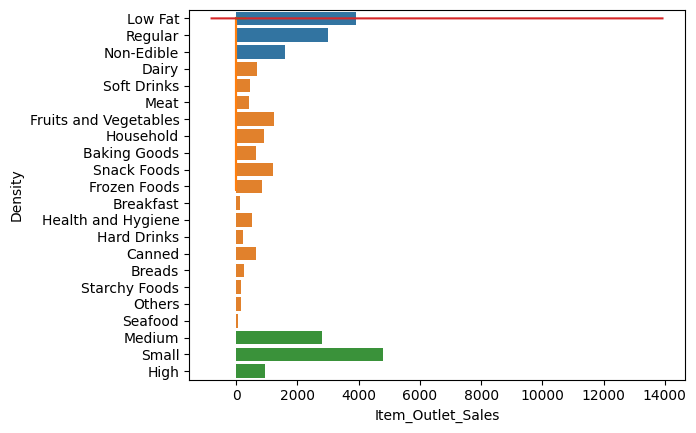

In [8]:
sns.distplot(df['Item_Weight'])
sns.distplot(df['Item_Visibility'])
sns.distplot(df['Item_MRP'])
sns.distplot(df['Item_Outlet_Sales'])
df['Item_Outlet_Sales'] = np.log1p(df['Item_Outlet_Sales'])

sns.countplot(df["Item_Fat_Content"])
sns.countplot(df['Item_Type'])
sns.countplot(df['Outlet_Size'])
# etc.


In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cat_cols = ['Item_Fat_Content','Item_Type','Outlet_Size','Outlet_Location_Type','Outlet_Type','New_Item_Type']
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

df = pd.get_dummies(df, columns=cat_cols)


In [10]:
X = df.drop(columns=['Outlet_Establishment_Year','Item_Identifier','Outlet_Identifier','Item_Outlet_Sales'])
y = df['Item_Outlet_Sales']

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

def train(model, X, y):
    model.fit(X, y)
    pred = model.predict(X)
    cv_score = np.abs(np.mean(cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)))
    print("MSE:", mean_squared_error(y, pred))
    print("CV Score:", cv_score)


In [12]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
train(model, X, y)


MSE: 0.2875379479991534
CV Score: 0.2896479964285261


In [14]:
from sklearn.linear_model import Ridge
model = Ridge()
train(model, X, y)


MSE: 0.28754220152354154
CV Score: 0.2896439797171585


In [15]:
from sklearn.linear_model import Lasso
model = Lasso()
train(model, X, y)


MSE: 0.7628688679102087
CV Score: 0.7630789166281843


In [16]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
train(model, X, y)


MSE: 2.7767015319289398e-34
CV Score: 0.5696026463987505


In [17]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
train(model, X, y)


MSE: 0.04263956884455617
CV Score: 0.31146032907522503


In [18]:
from sklearn.ensemble import ExtraTreesRegressor
train(model, X, y)


MSE: 0.04244518475731273
CV Score: 0.31066042986090936


In [27]:
# Define safe drop function
drop_cols = ['Item_Identifier', 'Item_Type', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']
existing_drop_cols = [col for col in drop_cols if col in df.columns]

X = df.drop(columns=existing_drop_cols)
y = df['Item_Outlet_Sales']


In [29]:
from sklearn.preprocessing import LabelEncoder
if 'Outlet_Identifier' in df.columns:
    le = LabelEncoder()
    df['Outlet_Identifier'] = le.fit_transform(df['Outlet_Identifier'])


In [30]:
# Drop or encode non-numeric columns
drop_cols = ['Item_Identifier', 'Item_Outlet_Sales']
existing_drop_cols = [col for col in drop_cols if col in df.columns]

X = df.drop(columns=existing_drop_cols)
y = df['Item_Outlet_Sales']

# Ensure all columns are numeric
X = X.select_dtypes(include=[np.number])

# Log-transform target
y_log = np.log1p(y)

# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Train the voting model
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, VotingRegressor

voting_model = VotingRegressor([
    ('ridge', Ridge(alpha=1.0)),
    ('lasso', Lasso(alpha=0.001)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
])
voting_model.fit(X_train, y_train)


VotingRegressor(estimators=[('ridge', Ridge()), ('lasso', Lasso(alpha=0.001)),
                            ('rf', RandomForestRegressor(random_state=42))])

In [31]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred_log = xgb_model.predict(X_test)
xgb_pred = np.expm1(xgb_pred_log)

xgb_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), xgb_pred))
print("XGBoost RMSE:", xgb_rmse)


XGBoost RMSE: 0.5249643575753198


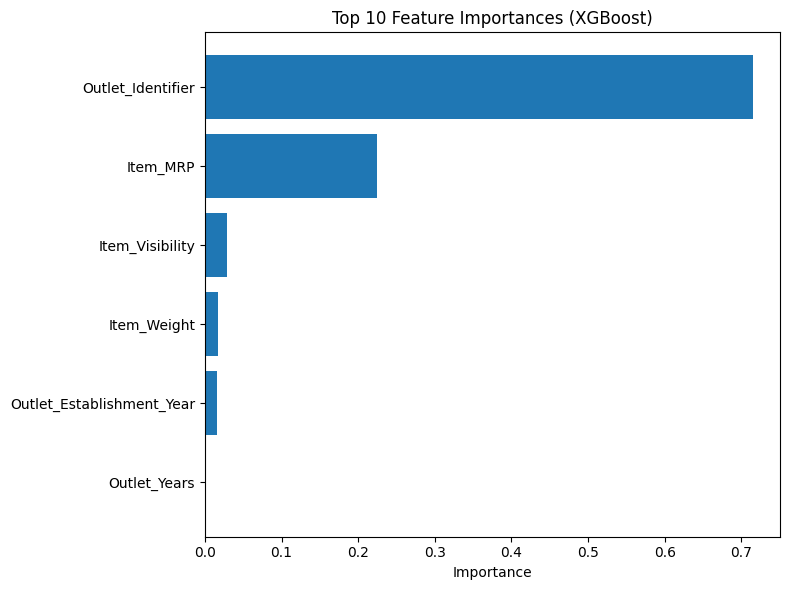

In [32]:
import matplotlib.pyplot as plt

feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[-10:]

plt.figure(figsize=(8, 6))
plt.barh(X.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()


In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20]
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_rf.fit(X_train, y_train)

print("Best Params:", grid_rf.best_params_)
print("Best RMSE:", -grid_rf.best_score_)


Best Params: {'max_depth': 10, 'n_estimators': 100}
Best RMSE: 0.06893614612633368


In [34]:
final_pred = voting_model.predict(X)
output = pd.DataFrame({
    'Item_Identifier': df['Item_Identifier'],
    'Outlet_Identifier': df['Outlet_Identifier'],
    'Predicted_Sales': np.expm1(final_pred)
})
output.to_csv('final_predictions.csv', index=False)
